<a href="https://colab.research.google.com/github/Hyeseong0317/Pytorch_Capstone_Design/blob/main/ResNet18_completion_short.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),                         
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),                        
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [6]:
data_dir = '/content/drive/Shareddrives/8:1:1_shortened/OCT2017(8:1:1)shortened'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in ['train', 'val', 'test']}


In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, drop_last=True, num_workers=4)
                    for x in ['train', 'val', 'test']}
        
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


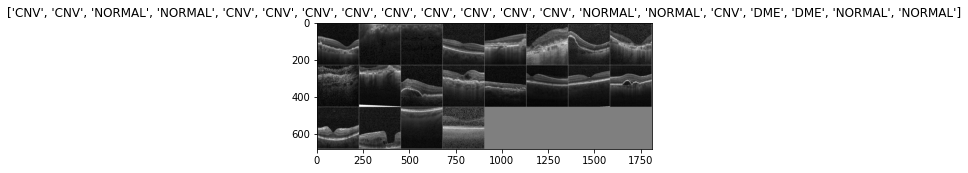

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
for id, data in enumerate(dataloaders['train']):
  print(id)
  img = data[0]
  label = data[1]
  print(img.shape)
  print(label.shape)
  break

0
torch.Size([20, 1, 224, 224])
torch.Size([20])


In [18]:
inputs = torch.Tensor(20, 1, 224, 224)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([20, 1, 224, 224])


In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses = []
    train_accuracies = []

    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_losses.append(epoch_loss)
              train_accuracies.append(epoch_acc)

            if phase == 'val':
              val_losses.append(epoch_loss)
              val_accuracies.append(epoch_acc)

            # 1 epoch 마다 loss 출력
            x_train_losses = np.arange(len(train_losses))
            x_val_losses = np.arange(len(val_losses))
            plt.plot(x_train_losses, train_losses)
            plt.plot(x_val_losses, val_losses)
            plt.show()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)

    return model, train_losses, train_accuracies, val_losses, val_accuracies # 5개의 변수를 반환

In [24]:
model_ft = ResNet18()

#os.chdir('/content/drive/Shareddrives/ResNet18_Model_parameters')
# Present working directory
#!pwd
#PATH = 'ResNet18_retina.pth'
# 학습된 모델 파라미터 로드
#model_ft.load_state_dict(torch.load(PATH))

In [25]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/29
----------


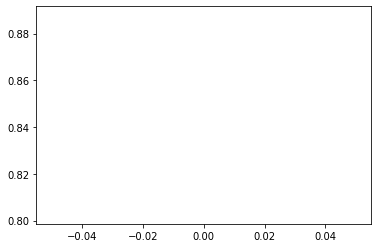

train Loss: 0.8451 Acc: 0.6820


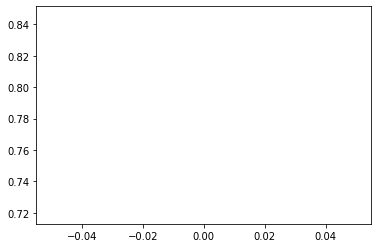

val Loss: 0.7193 Acc: 0.7062

Epoch 1/29
----------


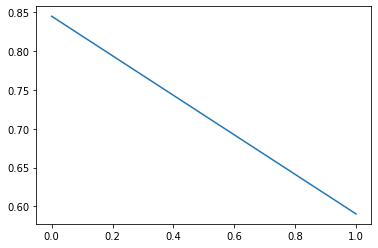

train Loss: 0.5903 Acc: 0.7784


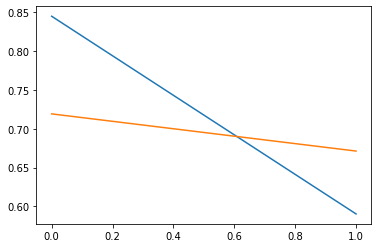

val Loss: 0.6714 Acc: 0.7530

Epoch 2/29
----------


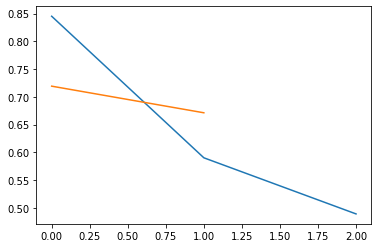

train Loss: 0.4893 Acc: 0.8178


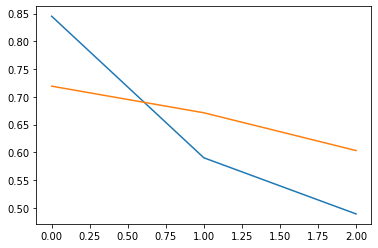

val Loss: 0.6034 Acc: 0.7931

Epoch 3/29
----------


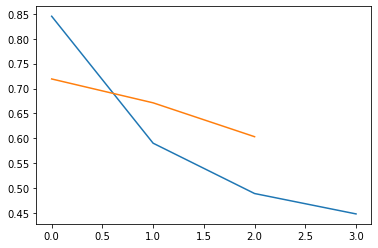

train Loss: 0.4484 Acc: 0.8338


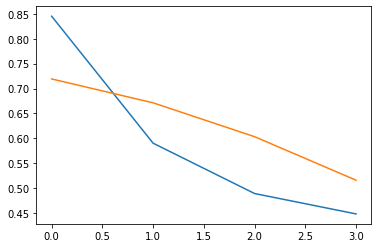

val Loss: 0.5161 Acc: 0.8098

Epoch 4/29
----------


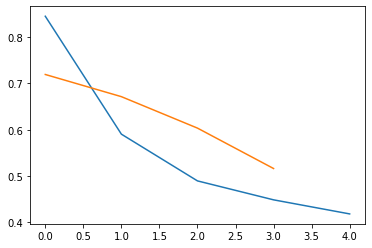

train Loss: 0.4179 Acc: 0.8467


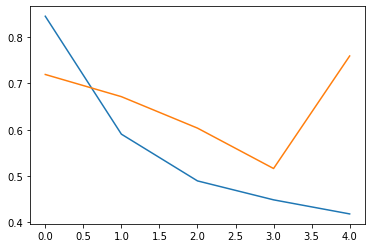

val Loss: 0.7593 Acc: 0.7324

Epoch 5/29
----------


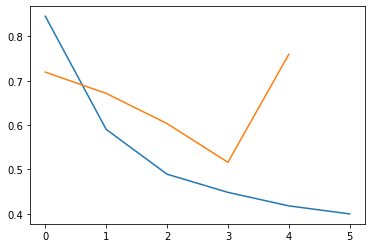

train Loss: 0.3998 Acc: 0.8530


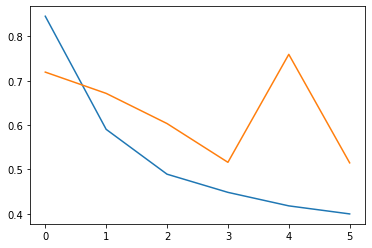

val Loss: 0.5149 Acc: 0.8208

Epoch 6/29
----------


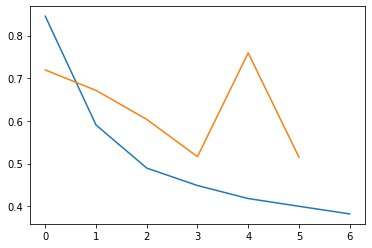

train Loss: 0.3819 Acc: 0.8596


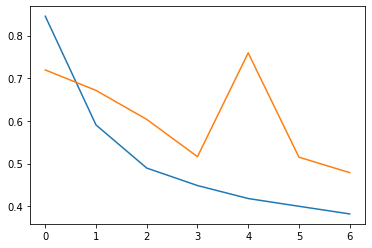

val Loss: 0.4786 Acc: 0.8265

Epoch 7/29
----------


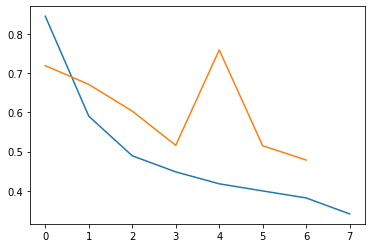

train Loss: 0.3412 Acc: 0.8758


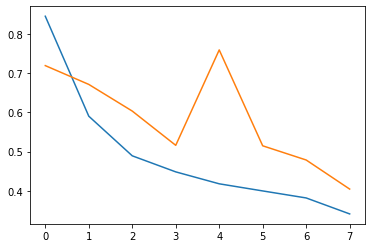

val Loss: 0.4045 Acc: 0.8410

Epoch 8/29
----------


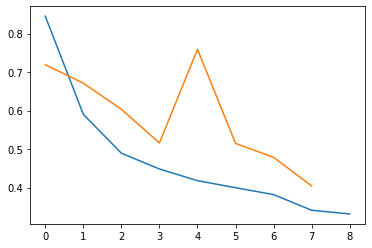

train Loss: 0.3317 Acc: 0.8792


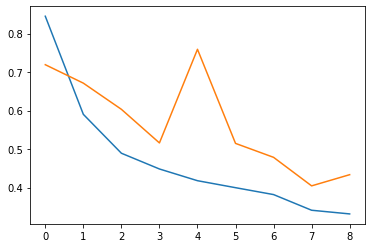

val Loss: 0.4336 Acc: 0.8442

Epoch 9/29
----------


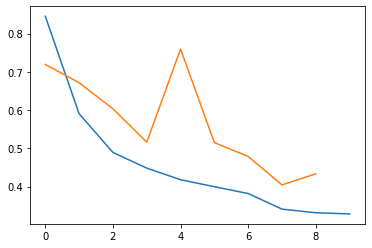

train Loss: 0.3287 Acc: 0.8804


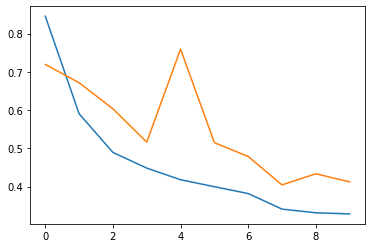

val Loss: 0.4124 Acc: 0.8453

Epoch 10/29
----------


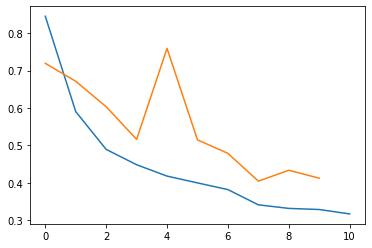

train Loss: 0.3169 Acc: 0.8838


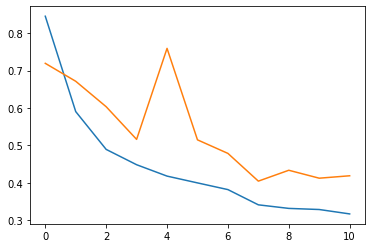

val Loss: 0.4188 Acc: 0.8375

Epoch 11/29
----------


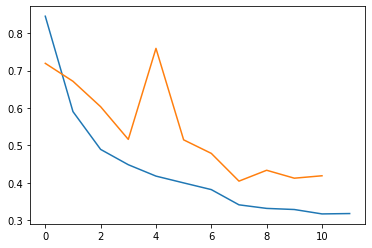

train Loss: 0.3179 Acc: 0.8826


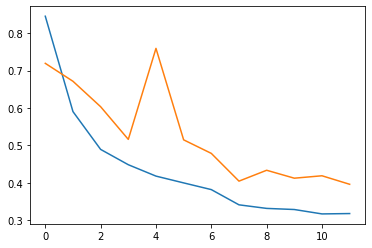

val Loss: 0.3961 Acc: 0.8552

Epoch 12/29
----------


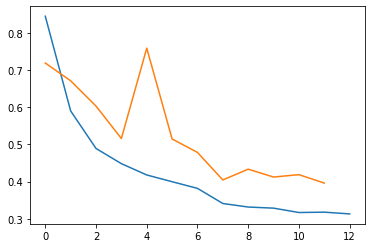

train Loss: 0.3131 Acc: 0.8867


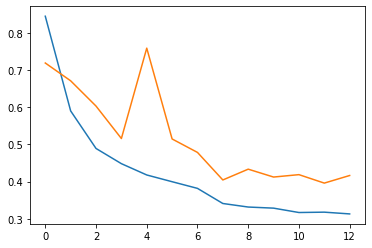

val Loss: 0.4165 Acc: 0.8446

Epoch 13/29
----------


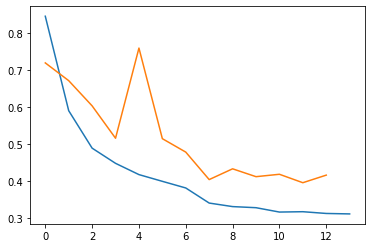

train Loss: 0.3119 Acc: 0.8861


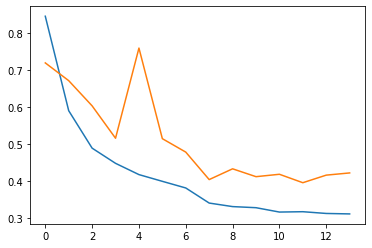

val Loss: 0.4225 Acc: 0.8417

Epoch 14/29
----------


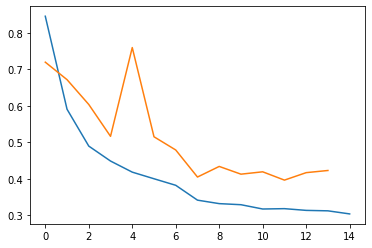

train Loss: 0.3035 Acc: 0.8884


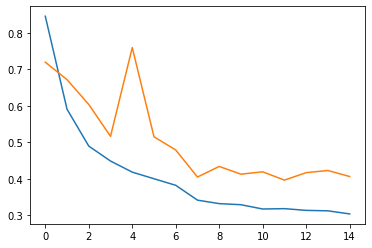

val Loss: 0.4059 Acc: 0.8446

Epoch 15/29
----------


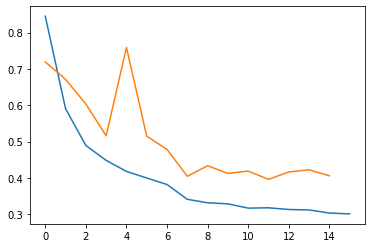

train Loss: 0.3010 Acc: 0.8900


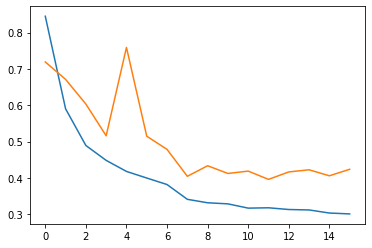

val Loss: 0.4238 Acc: 0.8442

Epoch 16/29
----------


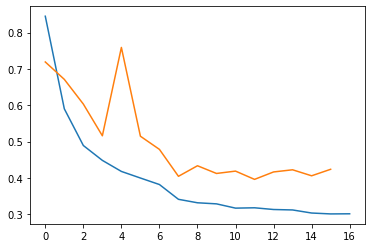

train Loss: 0.3013 Acc: 0.8899


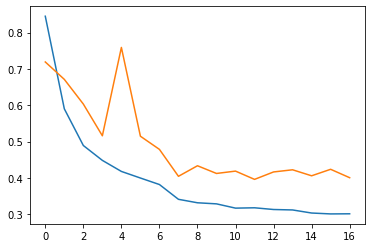

val Loss: 0.4007 Acc: 0.8538

Epoch 17/29
----------


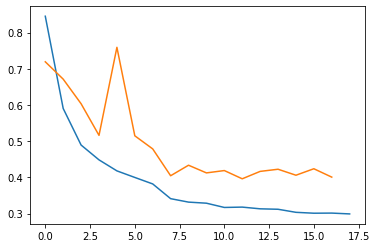

train Loss: 0.2991 Acc: 0.8891


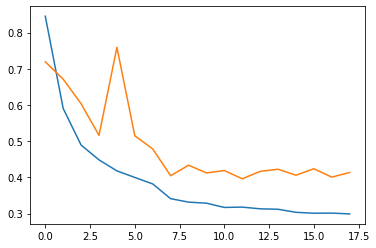

val Loss: 0.4134 Acc: 0.8499

Epoch 18/29
----------


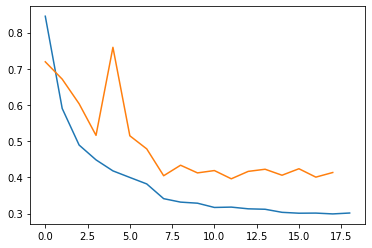

train Loss: 0.3015 Acc: 0.8896


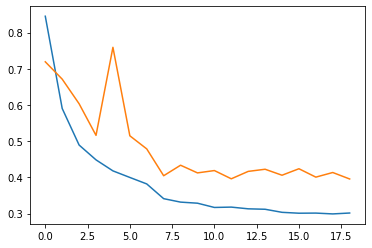

val Loss: 0.3956 Acc: 0.8510

Epoch 19/29
----------


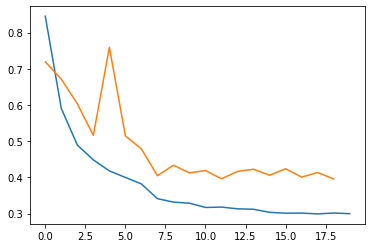

train Loss: 0.2997 Acc: 0.8919


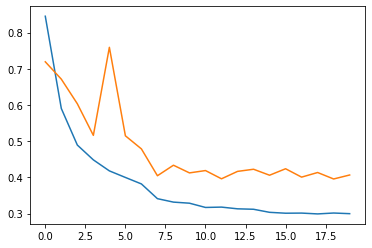

val Loss: 0.4066 Acc: 0.8524

Epoch 20/29
----------


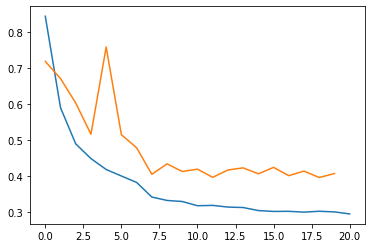

train Loss: 0.2941 Acc: 0.8928


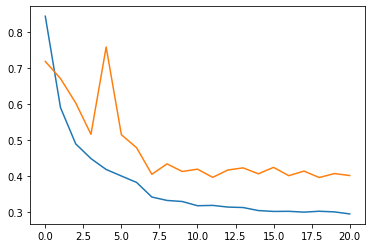

val Loss: 0.4011 Acc: 0.8542

Epoch 21/29
----------


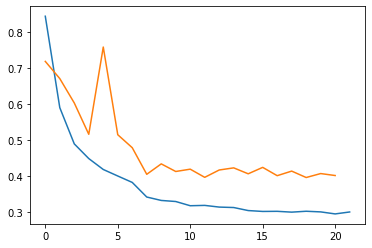

train Loss: 0.2995 Acc: 0.8897


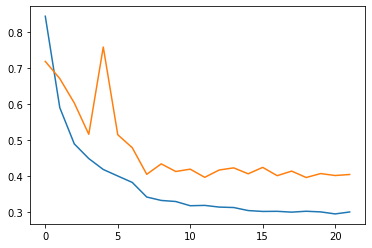

val Loss: 0.4040 Acc: 0.8478

Epoch 22/29
----------


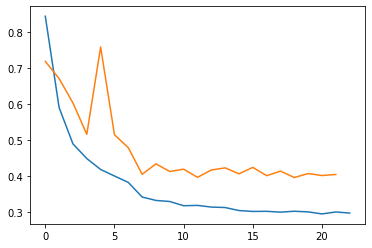

train Loss: 0.2965 Acc: 0.8922


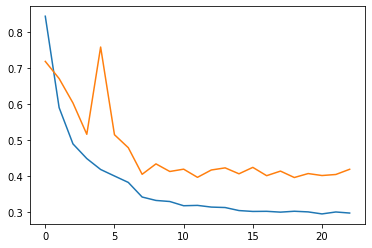

val Loss: 0.4185 Acc: 0.8456

Epoch 23/29
----------


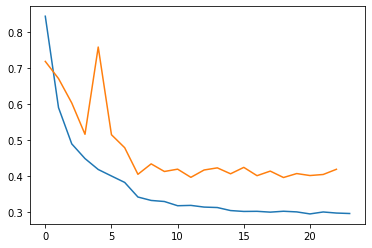

train Loss: 0.2952 Acc: 0.8936


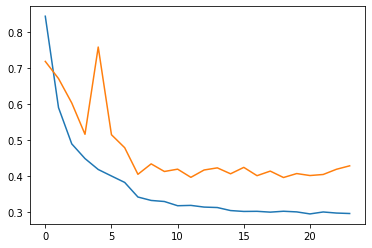

val Loss: 0.4282 Acc: 0.8453

Epoch 24/29
----------


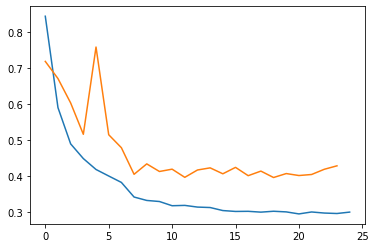

train Loss: 0.2991 Acc: 0.8912


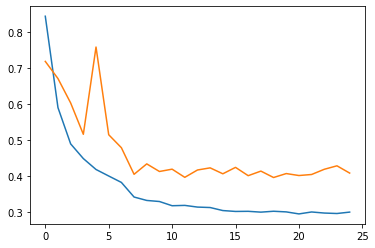

val Loss: 0.4079 Acc: 0.8488

Epoch 25/29
----------


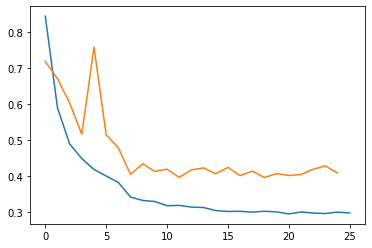

train Loss: 0.2966 Acc: 0.8928


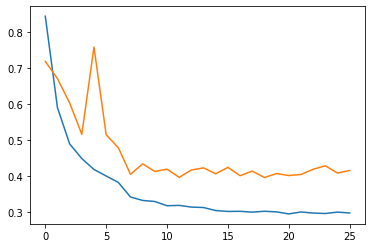

val Loss: 0.4150 Acc: 0.8485

Epoch 26/29
----------


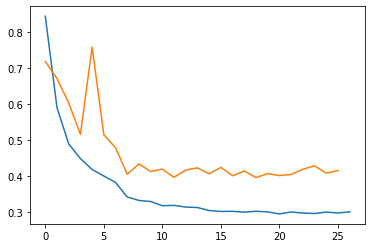

train Loss: 0.2999 Acc: 0.8908


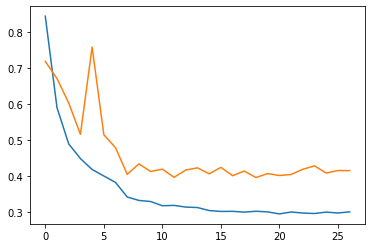

val Loss: 0.4148 Acc: 0.8453

Epoch 27/29
----------


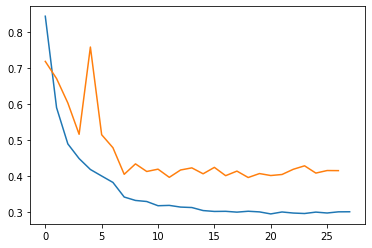

train Loss: 0.3001 Acc: 0.8909


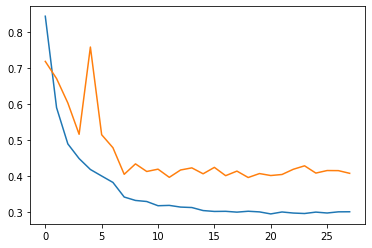

val Loss: 0.4073 Acc: 0.8442

Epoch 28/29
----------


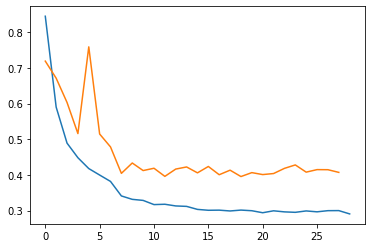

train Loss: 0.2908 Acc: 0.8938


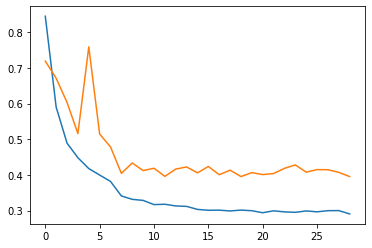

val Loss: 0.3956 Acc: 0.8595

Epoch 29/29
----------


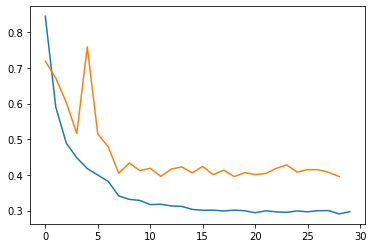

train Loss: 0.2970 Acc: 0.8907


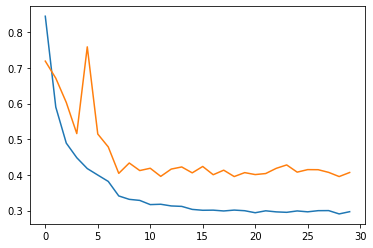

val Loss: 0.4069 Acc: 0.8432

Training complete in 143m 4s
Best val Acc: 0.859475


In [26]:
model_ft, train_losses, train_accuracies, val_losses, val_accuracies  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

In [2]:
os.chdir('/content/drive/Shareddrives/ResNet18_Model_parameters')

NameError: ignored

In [ ]:
# Present working directory
!pwd

/content/drive/Shareddrives/ResNet18_Model_parameters


In [ ]:
torch.save(model_ft.state_dict(), PATH)
print('Model Saved!')

Model Saved!


In [ ]:
net = ResNet18()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
net.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [1]:
def test_model(model, num_epochs=1):
    model.eval()
    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['test']:
            
            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
           

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

           
        print()

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))


In [ ]:
test_model = test_model(net)

Epoch 0/0
----------
test Loss: 1.3839 Acc: 0.1559

Testing complete in 25m 59s
Best Test Acc: 0.000000
